# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import copy
# matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
def make_dummy_from_list(df, col_name):
    """
    input : df with colulmn with list of values
    
    output: df with one hot encoding approach
    """

    dummy_df = pd.get_dummies(df[col_name].apply(pd.Series).stack(), prefix= col_name).sum(level=0)
    
    final_df = pd.concat([df, dummy_df], axis=1, sort=False)
    final_df.drop(columns=col_name, inplace=True)
    return final_df

In [3]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# 1. Data Clean up

## 1.a portfolio - offers Data Set

In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


We need to:
* create dummy variables for channels
* rename columns id that is reffering to offer
* change duration from days to hours

In [5]:
portfolio1 = make_dummy_from_list(portfolio, 'channels')
portfolio1 = portfolio1.rename(columns = {'id' : 'offer_id'})
portfolio1.duration = portfolio1.duration * 24
print(len(portfolio1))
portfolio1.head(20)

10


,reward,difficulty,duration,offer_type,offer_id,channels_email,channels_mobile,channels_social,channels_web
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


As we can see portfolio data set have 10 records and we don't have any other issues.

## 1.b profile - users Data Set

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [8]:
missing_age_rows = len(profile[profile['age'].isna()]) / len(profile)
missing_became_member_on_rows = len(profile[profile['became_member_on'].isna()]) / len(profile)
missing_gender_rows = len(profile[profile['gender'].isna()]) / len(profile)
missing_id_rows = len(profile[profile['id'].isna()]) / len(profile)
missing_income_rows = len(profile[profile['income'].isna()]) / len(profile)

print('missing rows:')
print(f'age = {missing_age_rows}')
print(f'became_member_on = {missing_became_member_on_rows}')
print(f'gender = {missing_gender_rows}')
print(f'id = {missing_id_rows}')
print(f'income = {missing_income_rows}')

missing rows:
age = 0.0
became_member_on = 0.0
gender = 0.12794117647058822
id = 0.0
income = 0.12794117647058822


### Age column investigation
We can see that mean values for **age** in our data set is a little too high - **62 years**.

<AxesSubplot:>

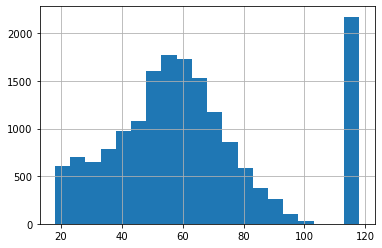

In [9]:
profile['age'].hist(bins = 20)

In [10]:
len(profile[(profile['age'] == 118) & (profile['gender'].isna())]) / len(profile[profile['age'] == 118])

1.0

In [11]:
len(profile[(profile['age'] == 118) & (profile['income'].isna())]) / len(profile[profile['age'] == 118])

1.0

### Age column solution
Since **100%** of rows with **age = 118** have missing values on **gender** and **income** columns we should drop those rows.
After that we don't have any missing values.

In [12]:
profile1 = profile[profile['age'] != 118]
profile1[profile1.isna().any(axis=1)].size

0

### Data preparation for further analysis
We need to:
* rename column id that is reffering to users
* change became_member_on format to date time format

In [13]:
profile1['became_member_on'] = pd.to_datetime(profile1['became_member_on'], format='%Y%m%d')
profile1 = profile1.rename(columns = {'id' : 'user_id'})
profile1.head()

<ipython-input-13-826d54204e5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile1['became_member_on'] = pd.to_datetime(profile1['became_member_on'], format='%Y%m%d')


,gender,age,user_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


## 1.c transcript - actions Data Set

In [14]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [15]:
transcript.count()

person    306534
event     306534
value     306534
time      306534
dtype: int64

In [16]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [17]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714], dtype=int64)

In [18]:
transcript.time.max()/24

29.75

### Data preprocessing
We have to split values from **value** column into seperate columns

In [19]:
transcript1 = copy.deepcopy(transcript)

transcript1['amount'] = transcript1.value.apply(lambda x: x['amount']*1.00 if 'amount' in x else None)
transcript1['reward'] = transcript1.value.apply(lambda x: x['reward']*1.00 if 'reward' in x else None)
transcript1['offer_id'] = transcript1.value.apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))

transcript1 = transcript1.drop(columns = ['value'])
transcript1 = transcript1.rename(columns = {'person' : 'user_id'})

transcript1.groupby(['event']).count()

person   value    time
prefix             event                                  
(amount,)          transaction      138953  138953  138953
(offer id,)        offer received    76277   76277   76277
                   offer viewed      57725   57725   57725
(offer_id, reward) offer completed   33579   33579   33579

In [25]:
transcript1.groupby(['event']).count()

,user_id,time,amount,reward,offer_id
event,,,,,
offer completed,33579,33579,0,33579,33579
offer received,76277,76277,0,0,76277
offer viewed,57725,57725,0,0,57725
transaction,138953,138953,138953,0,0


In [ ]:
len(transcript1[transcript1['event'] != 'transaction'])

In [ ]:
len(transcript1[transcript1['event'] == 'transaction'])

As we can see transaction event are not corelated with offer id.
We can split transcript dataset into two sub data sets:
* transcript_offer
* transcript_transaction

In [26]:
transcript_offer = transcript1[transcript1['event'] != 'transaction']
transcript_transaction = transcript1[transcript1['event'] == 'transaction']

In [27]:
# We drop unnecessery columns
transcript_offer = transcript_offer.drop(columns = ['amount'])
transcript_transaction = transcript_transaction.drop(columns = ['reward'])

In [28]:
# Rename values
transcript_offer['event'] = transcript_offer['event'].apply(lambda x: '3: offer completed' if x == 'offer completed' else 
                                                           ('1: offer received' if x == 'offer received' else '2: offer viewed'))

In [29]:
transcript_offer = transcript_offer.merge(portfolio1, how = 'left', on = 'offer_id')
transcript_offer = transcript_offer.rename(columns = {'reward_x' : 'reward_completed', 'reward_y' : 'reward_possible'})
transcript_offer.head()

,user_id,event,time,reward_completed,offer_id,reward_possible,difficulty,duration,offer_type,channels_email,channels_mobile,channels_social,channels_web
0,78afa995795e4d85b5d9ceeca43f5fef,1: offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,168,bogo,1,1,0,1
1,a03223e636434f42ac4c3df47e8bac43,1: offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,240,discount,1,0,0,1
2,e2127556f4f64592b11af22de27a7932,1: offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,2,10,168,discount,1,1,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,1: offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2,10,240,discount,1,1,1,1
4,68617ca6246f4fbc85e91a2a49552598,1: offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,120,bogo,1,1,1,1


In [30]:
min_i = transcript_offer.index.min()
transcript_offer[transcript_offer.index == min_i]

,user_id,event,time,reward_completed,offer_id,reward_possible,difficulty,duration,offer_type,channels_email,channels_mobile,channels_social,channels_web
0,78afa995795e4d85b5d9ceeca43f5fef,1: offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,168,bogo,1,1,0,1


In [ ]:
from tqdm.notebook import trange, tqdm

curr_sent_id = 0
offer_id_list = []


transcript_offer = transcript_offer.sort_values(by = ['user_id', 'offer_id', 'time'])

transcript_offer['sent_id'] = None
df_w = copy.deepcopy(transcript_offer)

for index, row in tqdm(transcript_offer.iterrows(), total=transcript_offer.shape[0]):
    if row['event'] == '1: offer received':
        curr_df = copy.deepcopy(transcript_offer[
                                    (transcript_offer['user_id'] == row['user_id']) & 
                                     (transcript_offer['offer_id'] == row['offer_id']) & 
                                     (transcript_offer['time'] >= row['time']) &
                                     (transcript_offer['time'] <= (row['time'] + row['duration'])) &
                                     (transcript_offer['sent_id'].isna())
                                      ])

        curr_df_viewed = curr_df[curr_df['event'] == '1: offer received']
        min_time = curr_df_viewed.time.min()
        curr_df_viewed = curr_df_viewed[curr_df_viewed.time == min_time]
        min_index = curr_df_viewed.index.min()
        curr_df_viewed = curr_df_viewed[curr_df_viewed.index == min_index]
        transcript_offer.loc[min_index, 'sent_id'] = curr_sent_id
        
        curr_df_viewed = curr_df[curr_df['event'] == '2: offer viewed']
        min_time = curr_df_viewed.time.min()
        curr_df_viewed = curr_df_viewed[curr_df_viewed.time == min_time]
        min_index = curr_df_viewed.index.min()
        curr_df_viewed = curr_df_viewed[curr_df_viewed.index == min_index]
        transcript_offer.loc[min_index, 'sent_id'] = curr_sent_id
        
        curr_df_viewed = curr_df[curr_df['event'] == '3: offer completed']
        min_time = curr_df_viewed.time.min()
        curr_df_viewed = curr_df_viewed[curr_df_viewed.time == min_time]
        min_index = curr_df_viewed.index.min()
        curr_df_viewed = curr_df_viewed[curr_df_viewed.index == min_index]
        transcript_offer.loc[min_index, 'sent_id'] = curr_sent_id
        
        curr_sent_id += 1
        
transcript_offer.to_csv('transcript_offer.csv')
transcript_offer.head()

  0%|          | 0/167582 [00:00<?, ?it/s]

In [ ]:
transcript_offer.to_csv('transcript_offer.csv')

In [ ]:
transcript_offer = pd.read_csv('transcript_offer.csv')

In [ ]:
transcript_offer_pivot = pd.pivot_table(transcript_offer, values=['time', 'reward_completed'], index=['user_id', 'offer_id', 'sent_id'], columns=['event'], aggfunc= 'sum')
transcript_offer_pivot.columns = transcript_offer_pivot.columns.droplevel()
transcript_offer_pivot = transcript_offer_pivot.reset_index(col_level=1)
transcript_offer_pivot = transcript_offer_pivot.reset_index(drop = True)
transcript_offer_pivot.columns = ['user_id', 'offer_id', 'sent_id' , '1: received reward',
                                  '2: viewed reward','3: completed reward', '1: received time',
                                  '2: viewed time','3: completed time']
transcript_offer_pivot.head(20)

# Merge Data Sets

In [ ]:
df = transcript_offer_pivot.merge(portfolio1, how = 'left', on = 'offer_id')
df = df.drop(columns = ['1: received reward', '2: viewed reward'])
df = df.rename(columns = {'3: completed reward' : 'completed reward'})
df[(~df['reward_completed'].isna()) & (df['reward_completed'] != df['reward'])].head()

In [ ]:
transcript_offer[transcript_offer['user_id'] == '0246e7cc7a3d4a98a940cb13776b5b55'].sort_values(by = ['user_id', 'offer_id', 'time'])